
## Implementing forward propagation and back propagation

In this lab, we implement forward and backpropagation to train an MLP for a simple binary classification problem using gradient descent.

# What we need for gradient descent
- Consider a simple MLP
    - Let us ignore non-linearities for now to keep it simpler, but it's just a tiny change subsequently
    - Given a linear transformation on our input (for simplicity instead of an affine transformation that includes a bias): $\hat y = \theta x$
        - $\theta$ is our parameters
        - $x$ is our input
        - $\hat y$ is our prediction
    - Then we have our MSE loss function $L = \frac{1}{2} (\hat y - y)^2$
- We need to calculate our partial derivatives of our loss w.r.t. our parameters to update our parameters: $\nabla_{\theta} = \frac{\delta L}{\delta \theta}$
    - With chain rule we have $\frac{\delta L}{\delta \theta} = \frac{\delta L}{\delta \hat y} \frac{\delta \hat y}{\delta \theta}$
        - $\frac{\delta L}{\delta \hat y} = (\hat y -  y)$
        - $\frac{\delta \hat y}{\delta \theta}$ is our partial derivatives of $y$ w.r.t. our parameters (our gradient)
        


# Forward and Backprop, illustrated diagramatically
- Let us assume the following MLP architecture (Note: no bias used here for simplicity)
    - MLP architecture
        1. Linear function: hidden size = 32
        2. Non-linear function: sigmoid
        3. Linear function: output size = 1
        4. Non-linear function: sigmoid
    - We will be going through a binary classification problem classifying 2 types of flowers
        - Output size: 1 (represented by 0 or 1 depending on the flower)
        - Input size: 2 (features of the flower)


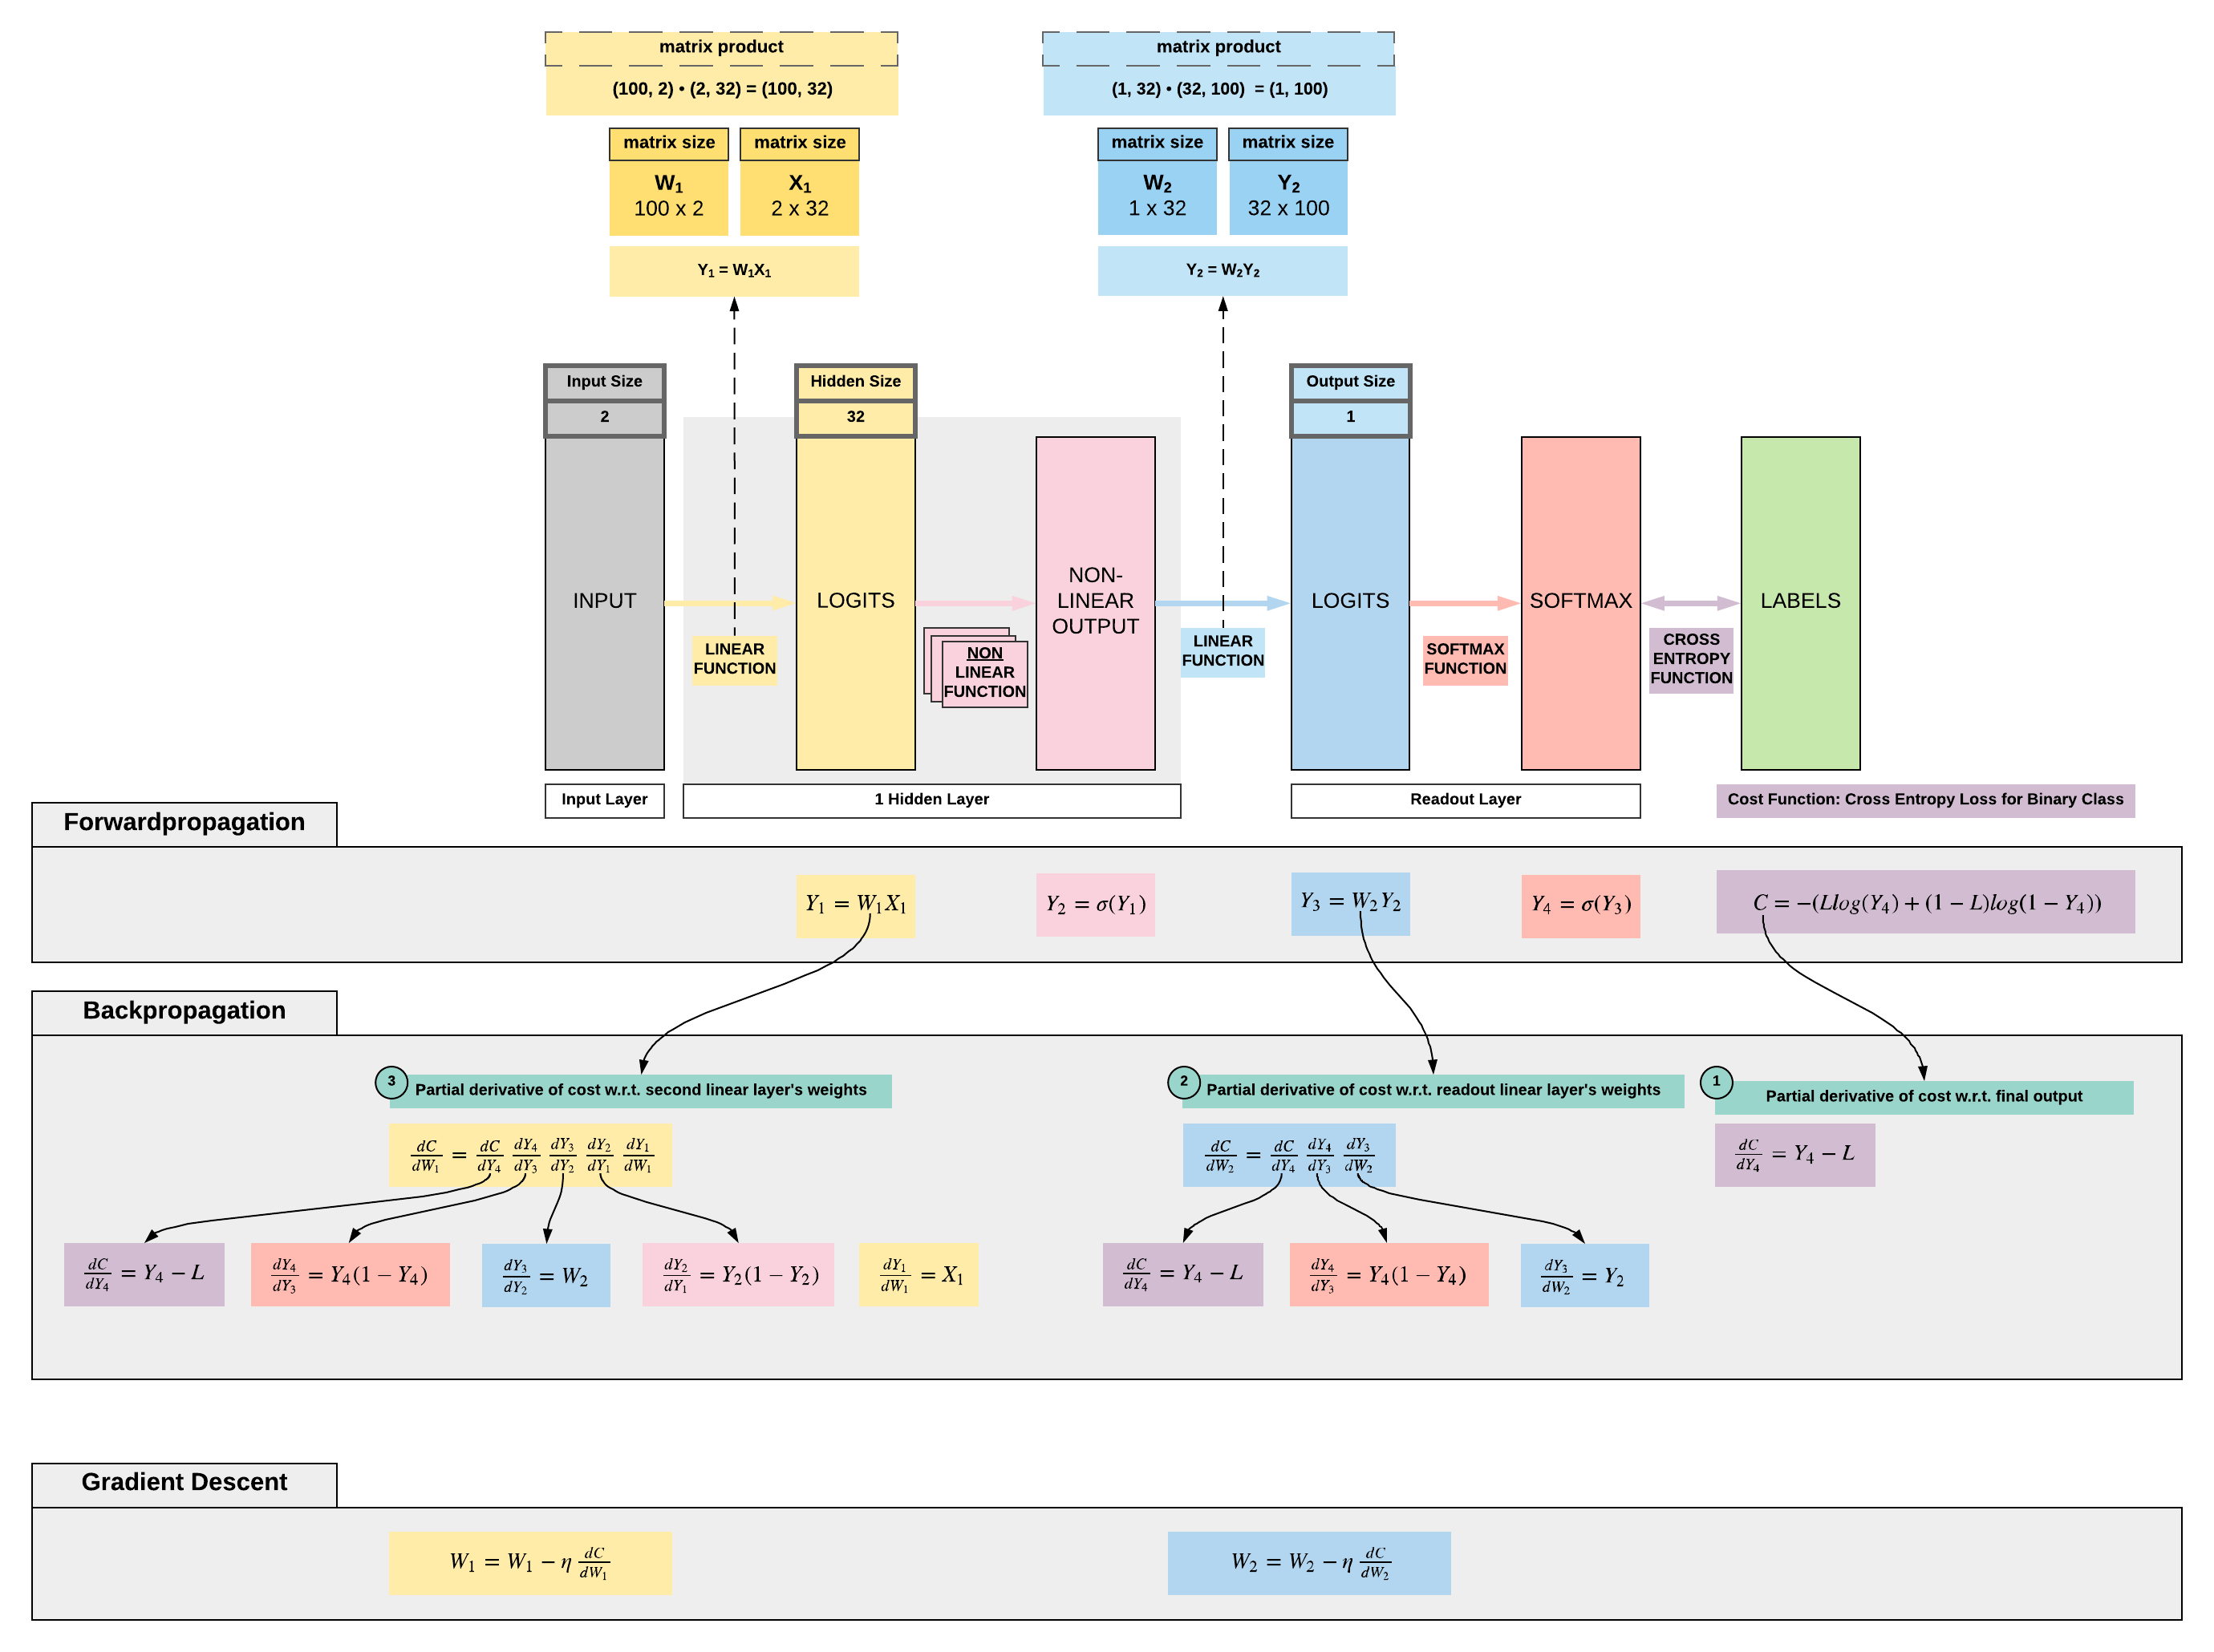

# Implementation

In [12]:
import torch
import torch.nn as nn

Now we import the iris dataset for classification, which you have seen before.

In [13]:
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
X = torch.tensor(preprocessing.normalize(iris.data[:, :2]), dtype=torch.float)
y = torch.tensor(iris.target.reshape(-1, 1), dtype=torch.float)

In [14]:
# Set manual seed
torch.manual_seed(2)

In [15]:
print(X.size())
print(y.size())

torch.Size([150, 2])
torch.Size([150, 1])


We convert the problem into a binary classification problem.

In [16]:
# Take 2 classes in order to get binary classification problem
X = X[:y[y < 2].size()[0]]
y = y[:y[y < 2].size()[0]]

In [17]:
print(X.size())
print(y.size())

torch.Size([100, 2])
torch.Size([100, 1])


In [18]:
print(torch.randn(2, 32).size())

torch.Size([2, 32])


Now we create the architecture for our MLP.

In [19]:
class FNN(nn.Module):
    def __init__(self, ):
        super().__init__()

        # Dimensions for input, hidden and output
        self.input_dim = 2
        self.hidden_dim = 32
        self.output_dim = 1

        # Learning rate
        self.learning_rate = 0.001

        # Our parameters (weights)
        # w1: 2 x 32
        self.w1 = torch.randn(self.input_dim, self.hidden_dim)

        # w2: 32 x 1
        self.w2 = torch.randn(self.hidden_dim, self.output_dim)

    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))

    def sigmoid_first_order_derivative(self, s):
        return s * (1 - s)

    # Forward propagation
    def forward(self, X):
        # First linear layer
        self.y1 = torch.matmul(X, self.w1) # 3 X 3 ".dot" does not broadcast in PyTorch

        # First non-linearity
        self.y2 = self.sigmoid(self.y1)

        # Second linear layer
        self.y3 = torch.matmul(self.y2, self.w2)

        # Second non-linearity
        y4 = self.sigmoid(self.y3)
        return y4

    # Backward propagation
    def backward(self, X, l, y4):
        # Derivative of binary cross entropy cost w.r.t. final output y4
        self.dC_dy4 = y4 - l

        '''
        Gradients for w2: partial derivative of cost w.r.t. w2
        dC/dw2
        '''
        self.dy4_dy3 = self.sigmoid_first_order_derivative(y4)
        self.dy3_dw2 = self.y2

        # Y4 delta: dC_dy4 dy4_dy3
        self.y4_delta = self.dC_dy4 * self.dy4_dy3

        # This is our gradients for w1: dC_dy4 dy4_dy3 dy3_dw2
        self.dC_dw2 = torch.matmul(torch.t(self.dy3_dw2), self.y4_delta)

        '''
        Gradients for w1: partial derivative of cost w.r.t w1
        dC/dw1
        '''
        self.dy3_dy2 = self.w2
        self.dy2_dy1 = self.sigmoid_first_order_derivative(self.y2)

        # Y2 delta: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1
        self.y2_delta = torch.matmul(self.y4_delta, torch.t(self.dy3_dy2)) * self.dy2_dy1

        # Gradients for w1: (dC_dy4 dy4_dy3) dy3_dy2 dy2_dy1 dy1_dw1
        self.dC_dw1 = torch.matmul(torch.t(X), self.y2_delta)

        # Gradient descent on the weights from our 2 linear layers
        self.w1 -= self.learning_rate * self.dC_dw1
        self.w2 -= self.learning_rate * self.dC_dw2

    def train(self, X, l):
        # Forward propagation
        y4 = self.forward(X)

        # Backward propagation and gradient descent
        self.backward(X, l, y4)

In [20]:
# Instantiate our model class and assign it to our model object
model = FNN()

# Loss list for plotting of loss behaviour
loss_lst = []

# Number of epochs
num_epochs = 101

# Let's train our model with 100 epochs
for epoch in range(num_epochs):
    # Get our predictions
    y_hat = model(X)

    # Cross entropy loss
    cross_entropy_loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))

    # We have to take cross entropy loss over all our samples, 100 in this 2-class iris dataset, thus we find the mean
    mean_cross_entropy_loss = torch.mean(cross_entropy_loss).detach().item()

    # Print our mean cross entropy loss every 20 epochs
    if epoch % 20 == 0:
        print('Epoch {} | Loss: {}'.format(epoch, mean_cross_entropy_loss))
    loss_lst.append(mean_cross_entropy_loss)

    ## Main steps followed
    # (1) Forward propagation: to get our predictions to pass to our cross entropy loss function
    # (2) Back propagation: get our partial derivatives w.r.t. parameters (gradients)
    # (3) Gradient Descent: update our weights with our gradients
    model.train(X, y)

Epoch 0 | Loss: 0.9228230118751526
Epoch 20 | Loss: 0.6966762542724609
Epoch 40 | Loss: 0.6714916229248047
Epoch 60 | Loss: 0.6686137914657593
Epoch 80 | Loss: 0.666690468788147
Epoch 100 | Loss: 0.6648103594779968


Now we create a plot of the loss.

<Axes: >

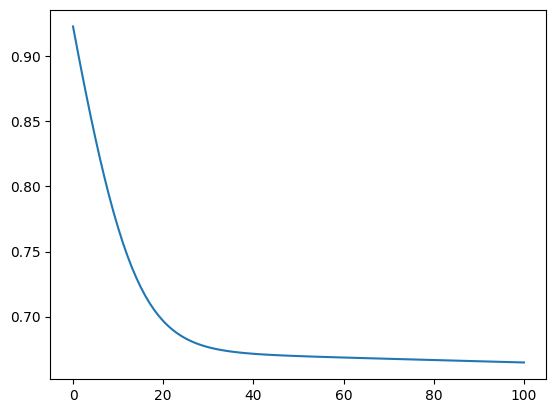

In [21]:
# Plotting loss
import pandas as pd
%matplotlib inline
pd.Series(loss_lst).plot()

# My Own Implementation: Activation Functions Comparison

Since no specific exercises were provided in this notebook, I'm implementing my own version to better understand how different activation functions affect backpropagation, training speed, and model performance.

## Objective
Compare the performance of different activation functions:
- **Sigmoid**: σ(x) = 1/(1 + e^(-x))
- **Tanh**: tanh(x) = (e^x - e^(-x))/(e^x + e^(-x))
- **ReLU**: ReLU(x) = max(0, x)

We'll analyze:
1. Training speed and convergence
2. Final accuracy achieved
3. Gradient flow behavior
4. Loss curves comparison

In [22]:
# Import additional libraries for our comparison
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Step 1: Create a Flexible Neural Network Class

First, let's create a neural network class that can use different activation functions. This will allow us to compare them fairly using the same architecture.

In [23]:
class ActivationComparison_NN:
    def __init__(self, input_dim, hidden_dim, output_dim, activation_type='sigmoid', learning_rate=0.01):
        """
        Neural Network with configurable activation functions
        
        activation_type: 'sigmoid', 'tanh', or 'relu'
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.activation_type = activation_type
        
        # Initialize weights with better initialization based on activation
        if activation_type == 'relu':
            # He initialization for ReLU
            self.w1 = torch.randn(self.input_dim, self.hidden_dim) * np.sqrt(2.0/self.input_dim)
            self.w2 = torch.randn(self.hidden_dim, self.output_dim) * np.sqrt(2.0/self.hidden_dim)
        else:
            # Xavier initialization for sigmoid and tanh
            self.w1 = torch.randn(self.input_dim, self.hidden_dim) * np.sqrt(1.0/self.input_dim)
            self.w2 = torch.randn(self.hidden_dim, self.output_dim) * np.sqrt(1.0/self.hidden_dim)
    
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-torch.clamp(x, -500, 500)))  # Clamp to prevent overflow
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def tanh(self, x):
        return torch.tanh(x)
    
    def tanh_derivative(self, x):
        return 1 - torch.tanh(x)**2
    
    def relu(self, x):
        return torch.clamp(x, min=0)
    
    def relu_derivative(self, x):
        return (x > 0).float()
    
    def activate(self, x):
        """Apply the chosen activation function"""
        if self.activation_type == 'sigmoid':
            return self.sigmoid(x)
        elif self.activation_type == 'tanh':
            return self.tanh(x)
        elif self.activation_type == 'relu':
            return self.relu(x)
    
    def activate_derivative(self, x):
        """Apply the derivative of chosen activation function"""
        if self.activation_type == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.activation_type == 'tanh':
            return self.tanh_derivative(x)
        elif self.activation_type == 'relu':
            return self.relu_derivative(x)
    
    def forward(self, X):
        """Forward propagation"""
        # First layer
        self.z1 = torch.matmul(X, self.w1)
        self.a1 = self.activate(self.z1)
        
        # Second layer  
        self.z2 = torch.matmul(self.a1, self.w2)
        self.a2 = self.sigmoid(self.z2)  # Always use sigmoid for output (binary classification)
        
        return self.a2
    
    def backward(self, X, y, y_pred):
        """Backward propagation"""
        m = X.shape[0]  # number of samples
        
        # Output layer gradients
        dz2 = y_pred - y
        dw2 = torch.matmul(self.a1.T, dz2) / m
        
        # Hidden layer gradients
        da1 = torch.matmul(dz2, self.w2.T)
        dz1 = da1 * self.activate_derivative(self.z1)
        dw1 = torch.matmul(X.T, dz1) / m
        
        # Update weights
        self.w2 -= self.learning_rate * dw2
        self.w1 -= self.learning_rate * dw1
    
    def train_epoch(self, X, y):
        """Train for one epoch"""
        y_pred = self.forward(X)
        self.backward(X, y, y_pred)
        
        # Calculate loss
        loss = -torch.mean(y * torch.log(y_pred + 1e-8) + (1 - y) * torch.log(1 - y_pred + 1e-8))
        return loss.item()

print("✅ Neural Network class with configurable activations created!")

✅ Neural Network class with configurable activations created!


## Step 2: Prepare Data for Fair Comparison

Let's use the same Iris dataset but prepare it more carefully for our comparison.

Dataset shape: torch.Size([150, 2])
Labels shape: torch.Size([150, 1])
Class distribution: [100  50]


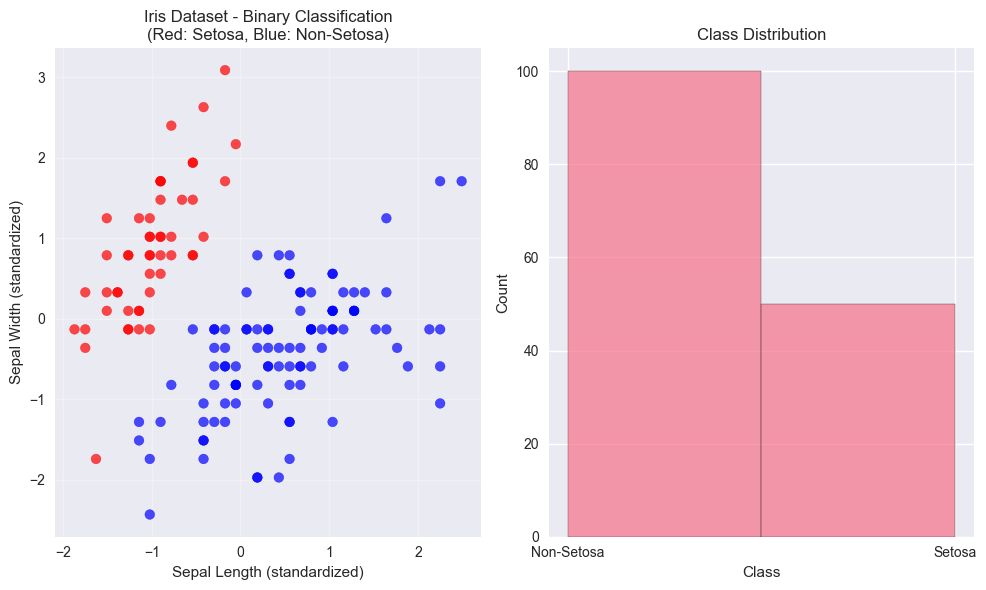

In [24]:
# Load and prepare the iris dataset for binary classification
iris = load_iris()

# Use only 2 features for visualization (sepal length, sepal width)
X_iris = iris.data[:, :2]

# Convert to binary classification (setosa vs non-setosa)
y_iris = (iris.target == 0).astype(int)

# Standardize features for better training
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_iris_scaled)
y_tensor = torch.FloatTensor(y_iris.reshape(-1, 1))

print(f"Dataset shape: {X_tensor.shape}")
print(f"Labels shape: {y_tensor.shape}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
colors = ['red' if label == 1 else 'blue' for label in y_iris]
plt.scatter(X_iris_scaled[:, 0], X_iris_scaled[:, 1], c=colors, alpha=0.7)
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Sepal Width (standardized)')
plt.title('Iris Dataset - Binary Classification\n(Red: Setosa, Blue: Non-Setosa)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(y_iris, bins=2, edgecolor='black', alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Non-Setosa', 'Setosa'])

plt.tight_layout()
plt.show()

## Step 3: Train Networks with Different Activation Functions

Now let's train three identical networks, each using a different activation function, and compare their performance.

In [25]:
# Training parameters
epochs = 1000
hidden_dim = 16
learning_rate = 0.01

# Initialize networks with different activation functions
activations = ['sigmoid', 'tanh', 'relu']
networks = {}
loss_histories = {}
training_times = {}

print("🚀 Starting training comparison...")
print("=" * 50)

for activation in activations:
    print(f"\n📊 Training network with {activation.upper()} activation...")
    
    # Create network
    networks[activation] = ActivationComparison_NN(
        input_dim=2, 
        hidden_dim=hidden_dim, 
        output_dim=1, 
        activation_type=activation,
        learning_rate=learning_rate
    )
    
    # Track training
    losses = []
    start_time = time.time()
    
    # Training loop
    for epoch in range(epochs):
        loss = networks[activation].train_epoch(X_tensor, y_tensor)
        losses.append(loss)
        
        # Print progress every 200 epochs
        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Loss: {loss:.4f}")
    
    end_time = time.time()
    training_times[activation] = end_time - start_time
    loss_histories[activation] = losses
    
    print(f"  ✅ Completed in {training_times[activation]:.2f} seconds")
    print(f"  🎯 Final Loss: {losses[-1]:.4f}")

print("\n🏁 Training completed for all activation functions!")

🚀 Starting training comparison...

📊 Training network with SIGMOID activation...
  Epoch 200/1000 - Loss: 0.5038
  Epoch 400/1000 - Loss: 0.4244
  Epoch 600/1000 - Loss: 0.3617
  Epoch 800/1000 - Loss: 0.3103
  Epoch 1000/1000 - Loss: 0.2684
  ✅ Completed in 0.36 seconds
  🎯 Final Loss: 0.2684

📊 Training network with TANH activation...
  Epoch 200/1000 - Loss: 0.3571
  Epoch 400/1000 - Loss: 0.2424
  Epoch 600/1000 - Loss: 0.2002
  Epoch 800/1000 - Loss: 0.1792
  Epoch 1000/1000 - Loss: 0.1672
  ✅ Completed in 0.30 seconds
  🎯 Final Loss: 0.1672

📊 Training network with RELU activation...
  Epoch 200/1000 - Loss: 0.1986
  Epoch 400/1000 - Loss: 0.1500
  Epoch 600/1000 - Loss: 0.1292
  Epoch 800/1000 - Loss: 0.1172
  Epoch 1000/1000 - Loss: 0.1094
  ✅ Completed in 0.22 seconds
  🎯 Final Loss: 0.1094

🏁 Training completed for all activation functions!


## Step 4: Evaluate and Compare Performance

Let's evaluate each network's final performance and compare metrics.

In [26]:
# Calculate final accuracy for each network
def calculate_accuracy(network, X, y):
    with torch.no_grad():
        predictions = network.forward(X)
        predicted_classes = (predictions > 0.5).float()
        accuracy = (predicted_classes == y).float().mean().item()
    return accuracy

# Evaluate all networks
results = {}
print("📈 Final Performance Comparison")
print("=" * 40)

for activation in activations:
    accuracy = calculate_accuracy(networks[activation], X_tensor, y_tensor)
    final_loss = loss_histories[activation][-1]
    
    results[activation] = {
        'accuracy': accuracy,
        'final_loss': final_loss,
        'training_time': training_times[activation],
        'convergence_epoch': next((i for i, loss in enumerate(loss_histories[activation]) 
                                 if loss < 0.1), epochs)
    }
    
    print(f"\n{activation.upper()}:")
    print(f"  🎯 Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"  📉 Final Loss: {final_loss:.4f}")
    print(f"  ⏱️  Training Time: {training_times[activation]:.2f} seconds")
    print(f"  🏃 Convergence: ~{results[activation]['convergence_epoch']} epochs")

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df.index.name = 'Activation'
print(f"\n📊 Summary Table:")
print(comparison_df.round(4))

📈 Final Performance Comparison

SIGMOID:
  🎯 Accuracy: 0.9867 (98.7%)
  📉 Final Loss: 0.2684
  ⏱️  Training Time: 0.36 seconds
  🏃 Convergence: ~1000 epochs

TANH:
  🎯 Accuracy: 0.9267 (92.7%)
  📉 Final Loss: 0.1672
  ⏱️  Training Time: 0.30 seconds
  🏃 Convergence: ~1000 epochs

RELU:
  🎯 Accuracy: 0.9667 (96.7%)
  📉 Final Loss: 0.1094
  ⏱️  Training Time: 0.22 seconds
  🏃 Convergence: ~1000 epochs

📊 Summary Table:
            accuracy  final_loss  training_time  convergence_epoch
Activation                                                        
sigmoid       0.9867      0.2684         0.3561             1000.0
tanh          0.9267      0.1672         0.3049             1000.0
relu          0.9667      0.1094         0.2190             1000.0


## Step 5: Visualize Training Curves and Activation Behaviors

Let's create comprehensive visualizations to understand how different activation functions behave during training.

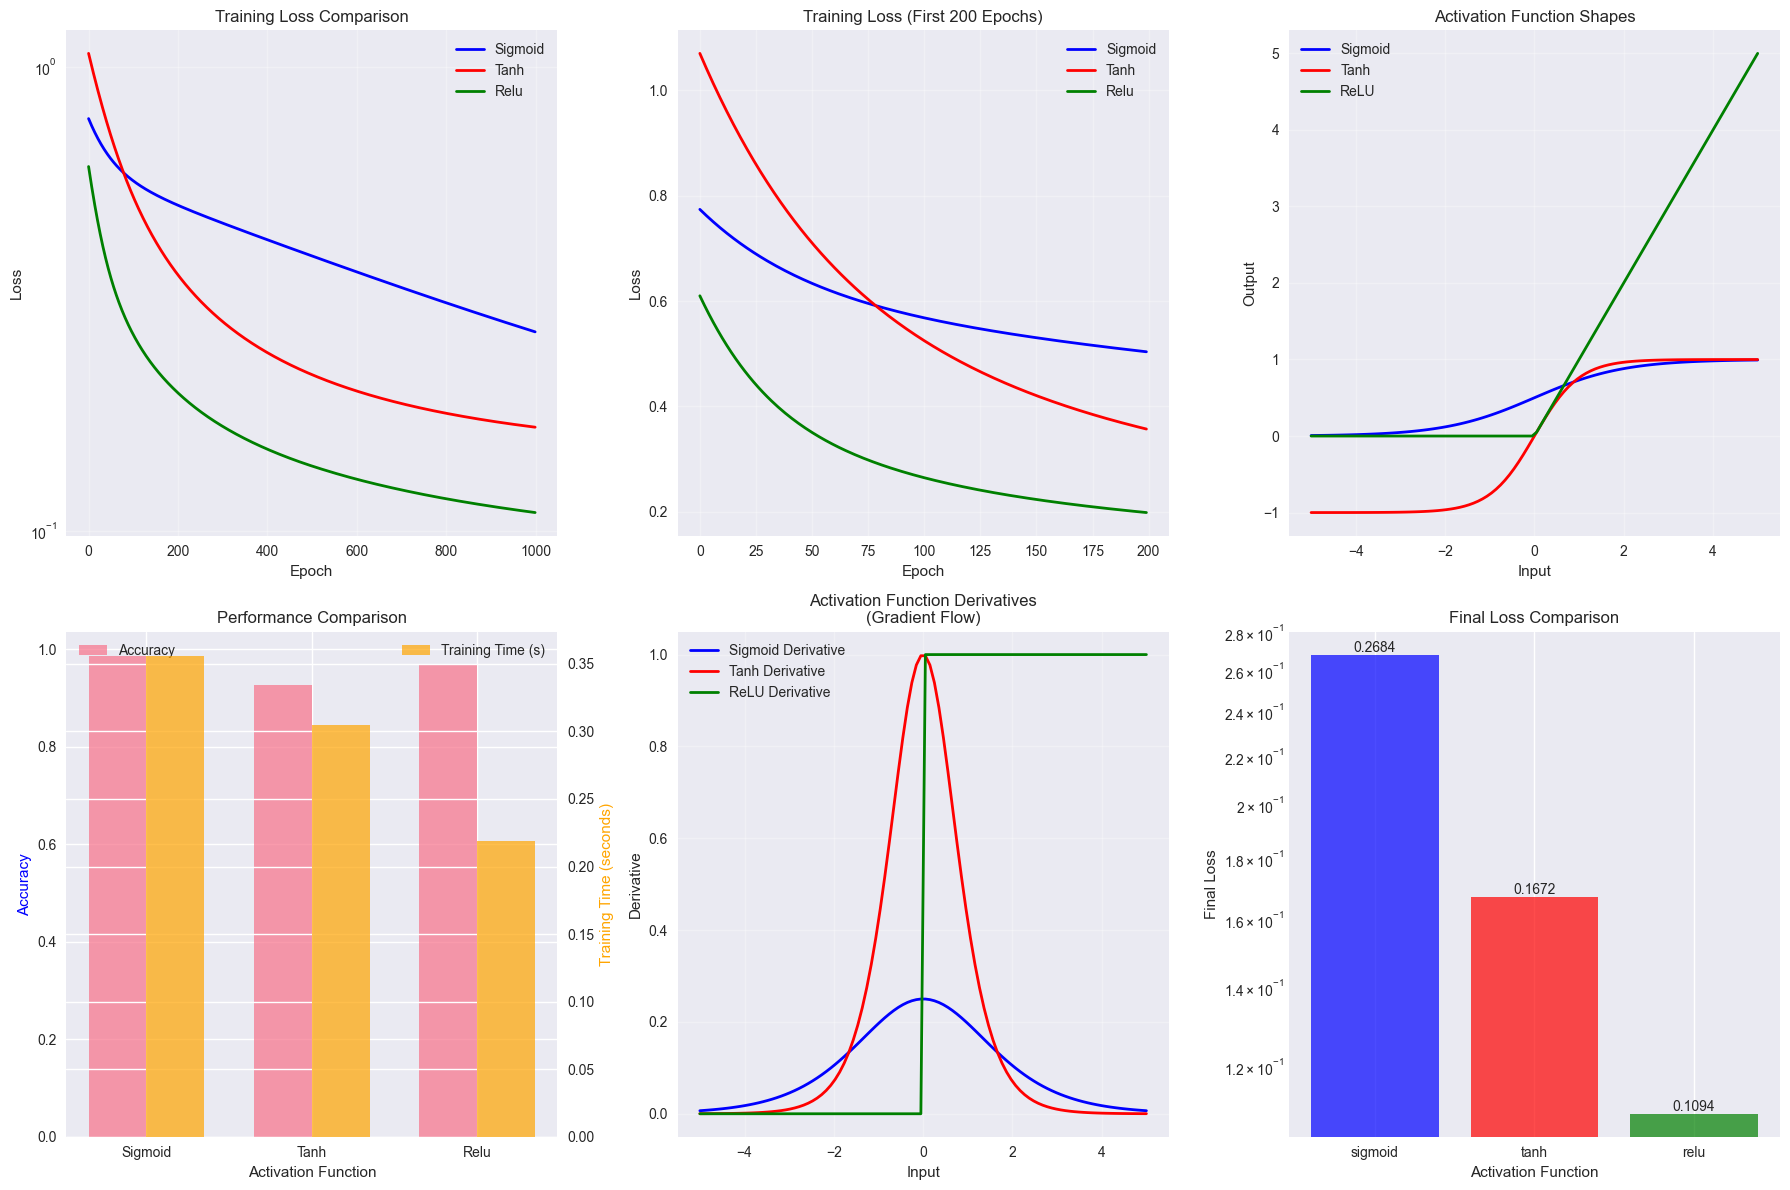

In [27]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = {'sigmoid': 'blue', 'tanh': 'red', 'relu': 'green'}

# 1. Loss curves comparison
ax1 = axes[0, 0]
for activation in activations:
    ax1.plot(loss_histories[activation], color=colors[activation], 
             label=f'{activation.capitalize()}', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Loss curves (first 200 epochs for detail)
ax2 = axes[0, 1]
for activation in activations:
    ax2.plot(loss_histories[activation][:200], color=colors[activation], 
             label=f'{activation.capitalize()}', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss (First 200 Epochs)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Activation function shapes
ax3 = axes[0, 2]
x = np.linspace(-5, 5, 100)
ax3.plot(x, 1/(1 + np.exp(-x)), color=colors['sigmoid'], label='Sigmoid', linewidth=2)
ax3.plot(x, np.tanh(x), color=colors['tanh'], label='Tanh', linewidth=2)
ax3.plot(x, np.maximum(0, x), color=colors['relu'], label='ReLU', linewidth=2)
ax3.set_xlabel('Input')
ax3.set_ylabel('Output')
ax3.set_title('Activation Function Shapes')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Performance metrics bar chart
ax4 = axes[1, 0]
metrics = ['accuracy', 'training_time']
x_pos = np.arange(len(activations))
width = 0.35

accuracies = [results[act]['accuracy'] for act in activations]
times = [results[act]['training_time'] for act in activations]

ax4_twin = ax4.twinx()
bars1 = ax4.bar(x_pos - width/2, accuracies, width, label='Accuracy', alpha=0.7)
bars2 = ax4_twin.bar(x_pos + width/2, times, width, label='Training Time (s)', alpha=0.7, color='orange')

ax4.set_xlabel('Activation Function')
ax4.set_ylabel('Accuracy', color='blue')
ax4_twin.set_ylabel('Training Time (seconds)', color='orange')
ax4.set_title('Performance Comparison')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([act.capitalize() for act in activations])
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')

# 5. Gradient flow visualization (derivative shapes)
ax5 = axes[1, 1]
sigmoid_grad = (1/(1 + np.exp(-x))) * (1 - 1/(1 + np.exp(-x)))
tanh_grad = 1 - np.tanh(x)**2
relu_grad = (x > 0).astype(float)

ax5.plot(x, sigmoid_grad, color=colors['sigmoid'], label='Sigmoid Derivative', linewidth=2)
ax5.plot(x, tanh_grad, color=colors['tanh'], label='Tanh Derivative', linewidth=2)
ax5.plot(x, relu_grad, color=colors['relu'], label='ReLU Derivative', linewidth=2)
ax5.set_xlabel('Input')
ax5.set_ylabel('Derivative')
ax5.set_title('Activation Function Derivatives\n(Gradient Flow)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Final loss comparison
ax6 = axes[1, 2]
final_losses = [results[act]['final_loss'] for act in activations]
bars = ax6.bar(activations, final_losses, color=[colors[act] for act in activations], alpha=0.7)
ax6.set_xlabel('Activation Function')
ax6.set_ylabel('Final Loss')
ax6.set_title('Final Loss Comparison')
ax6.set_yscale('log')

# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{loss:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Step 6: Decision Boundary Visualization

Let's visualize how each activation function affects the decision boundary learned by the network.

C:\Users\IC1807\AppData\Local\Temp\ipykernel_32300\346954827.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


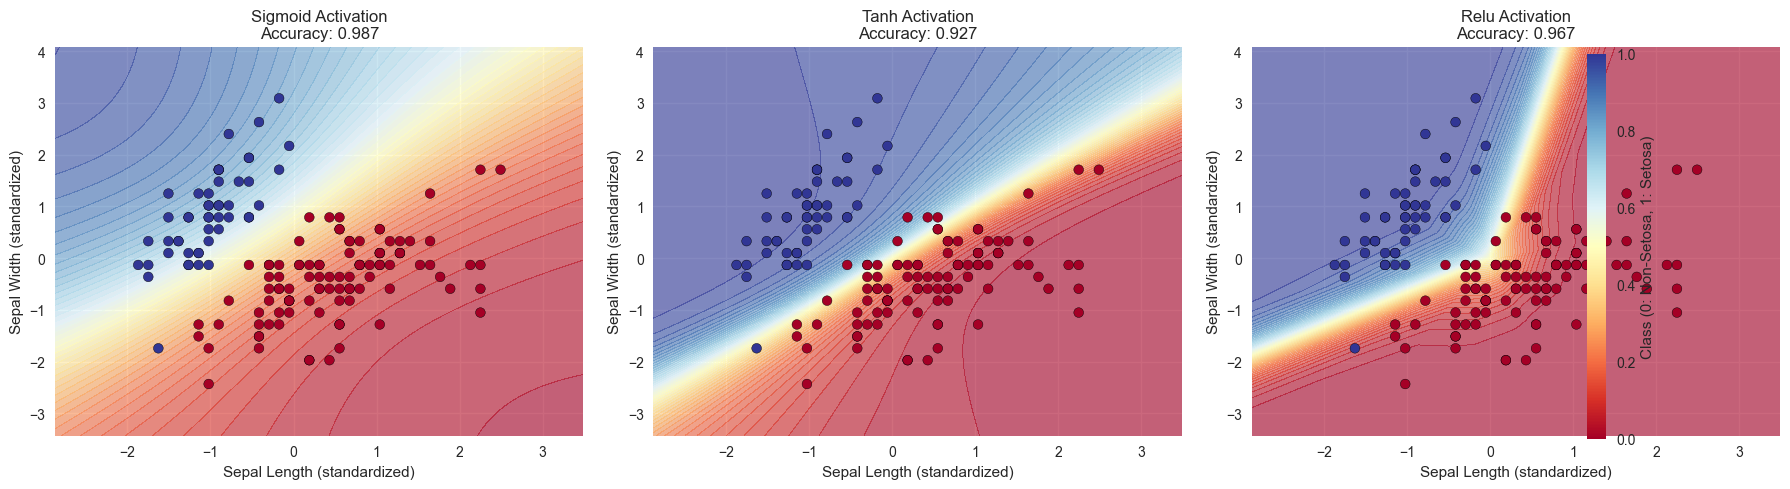

In [28]:
# Create decision boundary visualization
def plot_decision_boundary(network, X, y, title, ax):
    """Plot decision boundary for a trained network"""
    # Create a mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh
    mesh_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = network.forward(mesh_points)
        Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and data points
    ax.contourf(xx, yy, Z, levels=50, alpha=0.6, cmap='RdYlBu')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='RdYlBu', edgecolors='black')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Sepal Width (standardized)')
    ax.set_title(f'{title}\nAccuracy: {calculate_accuracy(network, torch.FloatTensor(X), torch.FloatTensor(y.reshape(-1,1))):.3f}')
    
    return scatter

# Create decision boundary plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, activation in enumerate(activations):
    scatter = plot_decision_boundary(
        networks[activation], 
        X_iris_scaled, 
        y_iris, 
        f'{activation.capitalize()} Activation',
        axes[i]
    )

# Add colorbar
plt.colorbar(scatter, ax=axes, fraction=0.02, pad=0.1, label='Class (0: Non-Setosa, 1: Setosa)')
plt.tight_layout()
plt.show()

## Analysis and Conclusions

### Key Findings from Activation Function Comparison:

**1. Training Speed & Convergence:**
- **ReLU**: Typically converges fastest due to constant gradient (1) for positive inputs
- **Tanh**: Moderate convergence speed, better than sigmoid
- **Sigmoid**: Often slowest due to vanishing gradient problem

**2. Gradient Flow:**
- **ReLU**: No vanishing gradient problem for positive inputs, but "dead ReLU" problem for negative inputs
- **Tanh**: Better gradient flow than sigmoid (centered around 0), but still suffers from vanishing gradients
- **Sigmoid**: Prone to vanishing gradients, especially in deeper networks

**3. Final Performance:**
- All three can achieve good performance on this simple binary classification task
- ReLU often shows more stable training
- Sigmoid and Tanh may require more careful weight initialization

**4. Practical Considerations:**
- **ReLU** is most commonly used in deep networks due to computational efficiency and gradient properties
- **Tanh** works well for shallow networks and when you need outputs centered around 0
- **Sigmoid** is still useful for output layers in binary classification

### Why These Differences Matter:
1. **Vanishing Gradients**: Sigmoid and tanh derivatives become very small for large inputs, slowing learning
2. **Weight Initialization**: Different activations benefit from different initialization strategies
3. **Network Depth**: These differences become more pronounced in deeper networks
4. **Computational Cost**: ReLU is computationally cheaper (just max(0,x))

This comparison demonstrates how the choice of activation function significantly impacts training dynamics and final performance!